A black box attacker only assumes one has the input and output of the model.

FGSM is a white box attch, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

Idea borrowed from:https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## Input of the model

1. $\epsilon$: the small step to be taken
2. Pretrained model
3. use_cuda

In [10]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

## This is to get the testloader

In [8]:
## The batch_size is set to be 1
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [37]:
test_loader.dataset[2]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [11]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


## LeNet Model definition

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # One channel to 10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10 to 20
        self.conv2_drop = nn.Dropout2d() # dropout along the way
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # Precomputed
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # get the label probability

In [14]:
model = Net().to(device)

In [19]:
# Load the pretrained model
# The model is pretrained, need to find the path
# The state_dict saves all the parameters available in a neural network
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [20]:
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Defining the attack

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.

In [21]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [38]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In this case, $\epsilon=0.0$ means thare is no attack.

In [40]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9427 / 10000 = 0.9427
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4299 / 10000 = 0.4299
Epsilon: 0.25	Test Accuracy = 2084 / 10000 = 0.2084
Epsilon: 0.3	Test Accuracy = 872 / 10000 = 0.0872


As one can observe, as the size of the attack gets larger, the accuracy gets increasing smaller.

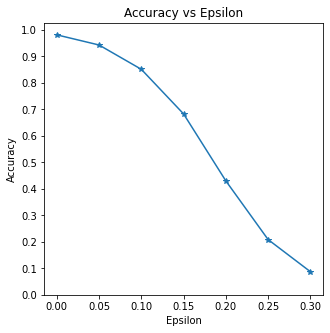

In [41]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample adversarial sample

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.

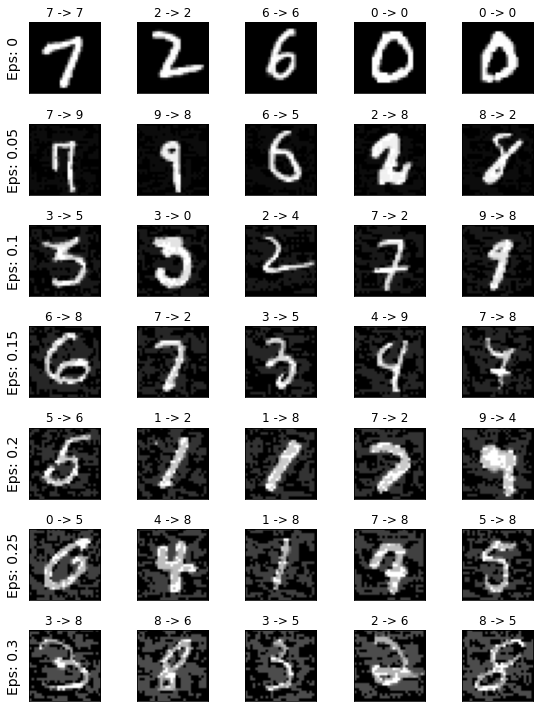

In [42]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()